# Script for Forest Loss
Nooriza Maharani

22 August 2025

This script is created with intention to document steps in preparing dataset to do forest loss analysis in Google Earth Engine. There are 3 outcomes generated from the pre-processed part. They are:
1) Terrestrial Mammals Area of Habitat Based on IUCN Red List Category listed as Critically Endangered, Endangered, and Vulnerable (shp format)
2) Birds Area of Habitat from Birdllife with Red List Category from IUCN (shp format)
3) Merge them together with attribute of scientific name, min_alt, max_alt, habitat, and IUCN Category.
4) Prepare the World Database of Protected Areas data

Meanwhile there are data visualisation script, which aim:
1) Identify species name that face habitat loss

# Part 1 : Script for Pre-processing Dataset 

## Preparing Area of Habitat (AOH) Mammals & Birds

Dataset used here:
1) Terrestrial mammal species range maps (IUCN) available at https://www.iucnredlist.org/resources/spatial-data-download (1 July 2025)
3) Bird Species' Species Range maps  freely requested from https://datazone.birdlife.org/contact-us/request-our-data (1 July 2025)
4) All species' habitat, minimum and maximum altitude are collected through IUCN Redlist Webpage by entering species' name one by one (July 2025), saved here with mammals_database.xls & bird_database.xls
5) Bird' IUCN redlist category available at https://datazone.birdlife.org/about-our-science/taxonomy (25 July 2025) named here as bird_iucn_taxonomy.xls file
6) World Database of Protected Areas (https://resources.unep-wcmc.org/) accessed on 14 August 2025
8) Borneo Boundary (gadm41_Borneo_IDN_1) downloaded at https://gadm.org/ simplify vertex at 200m using ArcgisPro, explode and delete small-scattered islands to avoid vertices issues except :
   - Maya Karimata island -1.1114594, 109.5900927 & -0.807859, 109.441845
   - Laut Selatan island -3.67704706, 116.1493258
   - Sebuku island -3.515927, 116.3694682
   - Mahakam Delta -0.663428, 117.401863
   - and Bulungan River Estuary 3.027885, 117.468919

In [17]:
import numpy as np
import matplotlib as plt
import geopandas as gpd
import os
import pandas as pd

In [3]:
os.getcwd()

'C:\\Users\\nooriza maharani\\Documents\\Dissertation'

In [2]:
borneo_boundary = gpd.read_file('gadm41_Borneo.shp')

In [28]:
mammal = gpd.read_file('MAMMALS_TERRESTRIAL_ONLY.shp')

In [27]:
bird = gpd.read_file('BOTW_2024_2.gpkg')

C:\Anaconda\Lib\site-packages\pyogrio\geopandas.py:275: UserWarning: More than one layer found in 'BOTW_2024_2.gpkg': 'all_species' (default), 'main_BL_HBW_Checklist_V9'. Specify layer parameter to avoid this warning.
  result = read_func(


In [7]:
borneo_boundary.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [33]:
mammal.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
bird.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Clipping Mammals with Borneo Boundary

In [38]:
# Cek geometri yang tidak valid
invalid = mammal[~mammal.is_valid]
print(invalid)

      id_no             sci_name  presence  origin  seasonal      compiler  \
2535   9760  Helarctos malayanus         5       1         1  Graham Usher   
9831  41772         Sus barbatus         1       1         1          IUCN   

      yrcompiled                                           citation  \
2535        2017               Scotson, L. and Fredriksson, G. 2016   
9831        2017  IUCN (International Union for Conservation of ...   

     subspecies subpop  ... marine terrestria freshwater  SHAPE_Leng  \
2535       None   None  ...  false       true      false  298.047663   
9831   barbatus   None  ...  false       true      false  203.352979   

      SHAPE_Area           area  \
2535   28.227425  347094.755252   
9831   29.450292  362205.059335   

                                                habitat altitude max_alt  \
2535          Forest, Shrubland, Artificial/Terrestrial      1.0  3000.0   
9831  Forest, Wetlands (inland), Marine Neritic, Mar...      0.0     0.0   


In [ ]:
# Cek geometri yang tidak valid
invalid = mammal[~mammal.is_valid]
print(invalid)

In [40]:
# Select animals which presence is not extinct and resident through the year
mammals_filtered = mammal[(mammal['presence'] != 5) & (mammal['seasonal'] == 1)].copy()

In [20]:
len(mammals_filtered)

12450

In [42]:
from shapely.validation import make_valid

mammals_filtered["geometry"] = mammals_filtered["geometry"].apply(make_valid)
borneo_boundary["geometry"] = borneo_boundary["geometry"].apply(make_valid)

In [44]:
mammals_borneo = gpd.clip(mammals_filtered, borneo_boundary)

In [ ]:
# Plot the clipped layer
mammals_borneo.plot(figsize=(10, 10), edgecolor='black', cmap='Set2')
plt.title("Clipped Mammals Layer")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [45]:
# Select animals where yrcompiled > 2000 and category as CR, VU, EN
mammals_threatened = mammals_borneo[
    (mammals_borneo['category'].isin(['VU', 'CR', 'EN'])) &
    (mammals_borneo['yrcompiled'] > 2000)
].copy()

In [ ]:
len(mammals_threatened)

In [48]:
# Reproject to Southeast Asia Albers Equal Area (ESRI:102025) in square metres
mammals_borneo_proj = mammals_threatened.to_crs("EPSG:3857")

# Calculate area in square meters
mammals_borneo_proj['area_m2'] = mammals_borneo_proj.geometry.area
mammals_borneo_proj['area_km2'] = mammals_borneo_proj['area_m2'] / 1_000_000
# Remove small areas possibly the result of clipping process
mammals_borneo_proj = mammals_borneo_proj[mammals_borneo_proj['area_km2'] >= 80]

In [ ]:
print(mammals_borneo_proj.columns.to_list())

In [50]:
# Sort by SHAPE_Area in descending order
mammals_sorted = mammals_borneo_proj.sort_values(by='area_km2', ascending=False)

# Display selected columns
#print(mammals_sorted[['sci_name', 'category', 'area_km2']])

In [52]:
# Merged duplicate species name
# Sort to keep largest area per species
sorted_gdf = mammals_borneo_proj.sort_values('area_km2', ascending=False)

# Group and pick first (largest area)
mammals_merged = (
    sorted_gdf
    .groupby('sci_name', as_index=False)
    .agg({
        'category': lambda x: ', '.join(sorted(set(x))),
        'yrcompiled': lambda x: ', '.join(map(str, sorted(set(x)))),
        'area_km2': 'first',
        'geometry': 'first'
    })
)

# Convert to GeoDataFrame again
import geopandas as gpd
mammals_merged = gpd.GeoDataFrame(mammals_merged, geometry='geometry', crs=mammals_borneo_proj.crs)

In [54]:
# Sort by SHAPE_Area in descending order
mammals_sort = mammals_merged.sort_values(by='sci_name', ascending=False)

# Display selected columns
print(mammals_sort[['sci_name', 'category', 'yrcompiled', 'area_km2']])

                     sci_name category yrcompiled       area_km2
47   Trachypithecus cristatus       VU       2020  532314.963439
46               Sus barbatus       VU       2017  407639.914177
45              Rusa unicolor       VU       2015  532314.768842
44       Rousettus spinalatus       VU       2021    6094.227837
43    Rhinolophus proconsulis       EN       2017     832.457002
42   Rheithrosciurus macrotis       VU       2008  532316.803770
41          Pteropus vampyrus       EN       2022  536617.843194
40  Pteromyscus pulverulentus       EN       2008   11596.625297
39           Presbytis sabana       EN       2020   11254.464192
38        Presbytis rubicunda       VU       2020  389588.885870
37            Presbytis hosei       VU       2021   40497.775511
36         Presbytis frontata       VU       2020  256409.240226
35      Presbytis chrysomelas       CR       2020   15117.642834
34         Presbytis canicrus       EN       2020   61851.018395
33             Pongo pygm

In [44]:
len(mammals_merged)

48

In [56]:
iucn_data = pd.read_excel('mammals_database.xls')

In [58]:
mammal_aoh = mammals_merged.merge(iucn_data, on = 'sci_name', how = 'left')

In [60]:
mammal_aoh= mammal_aoh.dropna(subset=['max_alt'])

In [62]:
mammal_aoh

,sci_name,category,yrcompiled,area_km2,geometry,habitat,min_alt,max_alt,alt_zone
0,Arctictis binturong,VU,2016,532314.768850,"MULTIPOLYGON (((13093262.075 463877.857, 13093...","Forest, Artificial/Terrestrial",0.0,3000.0,sub_alpine
1,Arielulus cuprosus,VU,2016,188.493255,"POLYGON ((12269470.387 114461.137, 12269376.12...",Forest,0.0,1784.0,lower_montane
2,Bos javanicus,CR,2024,36435.223382,"MULTIPOLYGON (((13089568.92 66715.999, 1309142...",Data not available,0.0,2100.0,upper_montane
3,Catopuma badia,EN,2016,184268.788529,"MULTIPOLYGON (((12887624.428 401376.615, 12894...",Data not available,0.0,800.0,hill
4,Cephalopachus bancanus,VU,2020,532195.597122,"MULTIPOLYGON (((13082705.259 -48286.3, 1308270...","Forest, Artificial/Terrestrial",0.0,1200.0,hill
6,Cynogale bennettii,EN,2015,411171.041133,"MULTIPOLYGON (((13093263.73 463878.086, 130932...",Data not available,0.0,1370.0,lower_montane
7,Dicerorhinus sumatrensis,CR,2020,532120.249008,"MULTIPOLYGON (((13001349.533 483642.843, 13001...",forest,0.0,2500.0,upper_montane
8,Diplogale hosei,VU,2015,60684.560752,"MULTIPOLYGON (((12479424.32 -110522.769, 12479...",Data not available,325.0,1700.0,lower_montane
9,Elephas maximus,EN,2020,939.033192,"MULTIPOLYGON (((12983492.528 478390.997, 12984...",Data not available,0.0,3000.0,sub_alpine
11,Helarctos malayanus,VU,2017,1101.178700,"POLYGON ((12925098.459 -440680.002, 12925310.3...",Data not available,1.0,3000.0,sub_alpine


In [64]:
len(mammal_aoh)

40

In [ ]:
#mammals_merged.to_file("mammals_merged.gpkg", driver = "GPKG")

In [ ]:
mammal_aoh.to_file("mammal_aoh.shp")

### Clipping Birds with Borneo Boundary

In [ ]:
# Invalid Geometry
invalid_bird = bird[~bird.is_valid]
print(invalid1)

In [ ]:
from shapely.validation import make_valid

bird["geometry"] = bird["geometry"].apply(make_valid)

In [66]:
bird_borneo = gpd.clip(bird, borneo_boundary)

In [62]:
bird_borneo.columns

Index(['OBJECTID', 'sisid', 'sci_name', 'presence', 'origin', 'seasonal',
       'source', 'compiler', 'data_sens', 'sens_comm', 'dist_comm', 'tax_comm',
       'generalisd', 'citation', 'yrcompiled', 'yrmodified', 'version',
       'geometry'],
      dtype='object')

In [ ]:
# Plot the clipped layer
bird_borneo.plot(figsize=(10, 10), edgecolor='black', cmap='Set2')
plt.title("Clipped bird Layer")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [68]:
# Select animals which presence is not extinct and resident through the year
bird_borneo_f = bird_borneo[(bird_borneo['presence'] != 5) & (bird_borneo['seasonal'] == 1) & (bird_borneo['yrcompiled'] > 2000)].copy()

In [70]:
iucn_data_bird = pd.read_excel('birds_iucn_taxonomy.xls')

In [72]:
bird_aoh = bird_borneo_f.merge(iucn_data_bird, on = 'sci_name', how = 'left')

In [74]:
birds_threatened_aoh = bird_aoh[bird_aoh['iucn_category'].isin(['VU', 'CR', 'EN'])].copy()

In [84]:
len(birds_threatened_aoh)

Index(['OBJECTID', 'sisid', 'sci_name', 'presence', 'origin', 'seasonal',
       'source', 'compiler', 'data_sens', 'sens_comm', 'dist_comm', 'tax_comm',
       'generalisd', 'citation', 'yrcompiled', 'yrmodified', 'version',
       'geometry', 'iucn_category'],
      dtype='object')

In [76]:
# Reproject to Southeast Asia Albers Equal Area (ESRI:102025) in square metres
bird_proj = birds_threatened_aoh.to_crs("EPSG:3857")

# Calculate area in square meters
bird_proj['area_m2'] = bird_proj.geometry.area
bird_proj['area_km2'] = bird_proj['area_m2'] / 1_000_000

In [78]:
# Merged duplicate species name
# Sort to keep largest area per species
bird_gdf = bird_proj.sort_values('area_km2', ascending=False)

# Group and pick first (largest area)
bird_merged = (
    bird_gdf
    .groupby('sci_name', as_index=False)
    .agg({
        'iucn_category': lambda x: ', '.join(sorted(set(x))),
        'yrcompiled': lambda x: ', '.join(map(str, sorted(set(x)))),
        'area_km2': 'first',
        'geometry': 'first'
    })
)

# Convert to GeoDataFrame again
import geopandas as gpd
bird_merged = gpd.GeoDataFrame(bird_merged, geometry='geometry', crs=bird_proj.crs)

In [80]:
# Sort by SHAPE_Area in descending order
bird_sort = bird_merged.sort_values(by='area_km2', ascending=False)

# Display selected columns
print(bird_sort[['sci_name', 'iucn_category', 'yrcompiled', 'area_km2']])

                      sci_name iucn_category yrcompiled       area_km2
25        Rhyticeros undulatus            VU     2009.0  536279.777461
3             Argusianus argus            VU     2006.0  536279.777273
7           Buceros rhinoceros            VU     2006.0  536279.503422
10        Chloropsis sonnerati            EN     2009.0  505194.452636
19              Nisaetus nanus            VU     2013.0  460928.000708
18  Mulleripicus pulverulentus            VU     2007.0  448648.241277
6         Berenicornis comatus            EN     2014.0  425282.317635
12         Geokichla interpres            EN     2020.0  422161.444278
24  Rhabdotorrhinus corrugatus            EN     2009.0  377590.098030
5       Belocercus longicaudus            VU     2016.0  373974.646280
11              Ciconia stormi            EN     2013.0  372091.115435
15              Lophura ignita            VU     2012.0  371366.824025
29          Treron fulvicollis            VU     2013.0  358901.079021
1     

In [82]:
altitude = pd.read_excel('birds_database.xls')

In [84]:
aoh_bird = bird_merged.merge(altitude, on = 'sci_name', how = 'left')

In [92]:
print(aoh_bird)

                      sci_name iucn_category yrcompiled       area_km2  \
0       Acridotheres javanicus            VU     2020.0  302491.044473   
1       Alophoixus tephrogenys            VU     2016.0  348518.883046   
2      Anthracoceros malayanus            VU     2009.0  330498.737948   
3             Argusianus argus            VU     2006.0  536279.777273   
4       Batrachostomus auritus            VU     2022.0  249673.599230   
5       Belocercus longicaudus            VU     2016.0  373974.646280   
6         Berenicornis comatus            EN     2014.0  425282.317635   
7           Buceros rhinoceros            VU     2006.0  536279.503422   
8         Carpococcyx radiceus            VU     2022.0  188410.814358   
9         Centropus rectunguis            VU     2022.0  236138.034040   
10        Chloropsis sonnerati            EN     2009.0  505194.452636   
11              Ciconia stormi            EN     2013.0  372091.115435   
12         Geokichla interpres        

In [86]:
# Remove Padda oryzivora as this species doesnt include forest as their habitat
aoh_bird = aoh_bird[aoh_bird['sci_name'] != 'Padda oryzivora']

In [92]:
aoh_bird= aoh_bird.dropna(subset=['max_alt'])
len(aoh_bird)

26

In [96]:
aoh_bird = aoh_bird.rename(columns={'iucn_category': 'category'})

In [ ]:
#aoh_bird.to_file("aoh_bird.shp")

In [98]:
#Merging Mammal and Birds

# Identify common columns (excluding geometry)
common_cols = list(set(aoh_bird.columns).intersection(set(mammal_aoh.columns)))
common_cols = [col for col in common_cols if col != 'geometry']

# Align both GeoDataFrames
bird_aligned = aoh_bird[common_cols + ['geometry']]
mammal_aligned = mammal_aoh[common_cols + ['geometry']]

In [150]:
bird_aligned['class'] = 'Aves'
mammal_aligned['class'] = 'Mammalia'

In [152]:
# Merge them
merged = pd.concat([bird_aligned, mammal_aligned], ignore_index=True)
merged_gdf = gpd.GeoDataFrame(merged, crs=aoh_bird.crs)

# Save the merged shapefile
merged_gdf.to_file("merged_aoh_class.shp")

In [15]:
import geopandas as gpd
m = gpd.read_file("aoh_bird.shp")
mm = gpd.read_file("mammal_aoh.shp")

In [154]:
merged_gdf

,max_alt,yrcompiled,sci_name,min_alt,habitat,category,area_km2,geometry,class
0,1150.0,2016.0,Alophoixus tephrogenys,0.0,"Forest, Artificial/Terrestrial",VU,348518.883046,"MULTIPOLYGON (((13093275.664 463888.608, 13093...",Aves
1,200.0,2009.0,Anthracoceros malayanus,0.0,Forest,VU,330498.737948,"MULTIPOLYGON (((12171506.253 2880.827, 1222941...",Aves
2,1500.0,2006.0,Argusianus argus,0.0,Forest,VU,536279.777273,"MULTIPOLYGON (((13093275.664 463888.608, 13093...",Aves
3,300.0,2022.0,Batrachostomus auritus,0.0,Forest,VU,249673.599230,"MULTIPOLYGON (((13078179.218 464175.34, 130778...",Aves
4,300.0,2016.0,Belocercus longicaudus,0.0,"Forest, Artificial/Terrestrial",VU,373974.646280,"MULTIPOLYGON (((13082703.574 -48288.28, 130814...",Aves
...,...,...,...,...,...,...,...,...,...
61,1200.0,2022,Pteropus vampyrus,0.0,Data not available,EN,536617.843194,"MULTIPOLYGON (((12915966.371 -385933.948, 1291...",Mammalia
62,1100.0,2008,Rheithrosciurus macrotis,0.0,Forest,VU,532316.803770,"MULTIPOLYGON (((13071334.984 -94476.344, 13071...",Mammalia
63,1100.0,2021,Rousettus spinalatus,0.0,Data not available,VU,6094.227837,"POLYGON ((12708206.56 -4418.363, 12708026.817 ...",Mammalia
64,3900.0,2015,Rusa unicolor,0.0,"Forest, Savanna, Shrubland, Grassland, Wetland...",VU,532314.768842,"MULTIPOLYGON (((13093262.075 463877.857, 13093...",Mammalia


## World Database of Protected Areas

In [8]:
wdpa_0 = gpd.read_file('WDPA_Aug2025_Public_shp-polygons0.shp')
wdpa_1 = gpd.read_file('WDPA_Aug2025_Public_shp-polygons1.shp')
wdpa_2 = gpd.read_file('WDPA_Aug2025_Public_shp-polygons2.shp')

In [19]:
from shapely.validation import make_valid

wdpa_0["geometry"] = wdpa_0["geometry"].apply(make_valid)

In [29]:
wdpa_1["geometry"] = wdpa_1["geometry"].apply(make_valid)
wdpa_2["geometry"] = wdpa_2["geometry"].apply(make_valid)

In [31]:
borneo_boundary["geometry"] = borneo_boundary["geometry"].apply(make_valid)
wdpa_0_c = gpd.clip(wdpa_0, borneo_boundary)
wdpa_1_c = gpd.clip(wdpa_1, borneo_boundary)
wdpa_2_c = gpd.clip(wdpa_2, borneo_boundary)

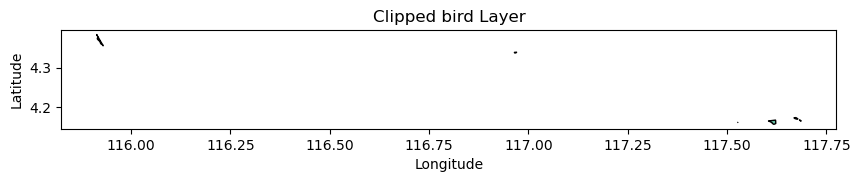

In [35]:
import matplotlib.pyplot as plt
# Plot the clipped layer
wdpa_2_c.plot(figsize=(10, 10), edgecolor='black', cmap='Set2')
plt.title("Layer")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [39]:
from geopandas import overlay
# Union
union = gpd.overlay(wdpa_0_c, wdpa_1_c, how="union")
union1 = gpd.overlay(union, wdpa_2_c, how="union")

C:\Anaconda\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


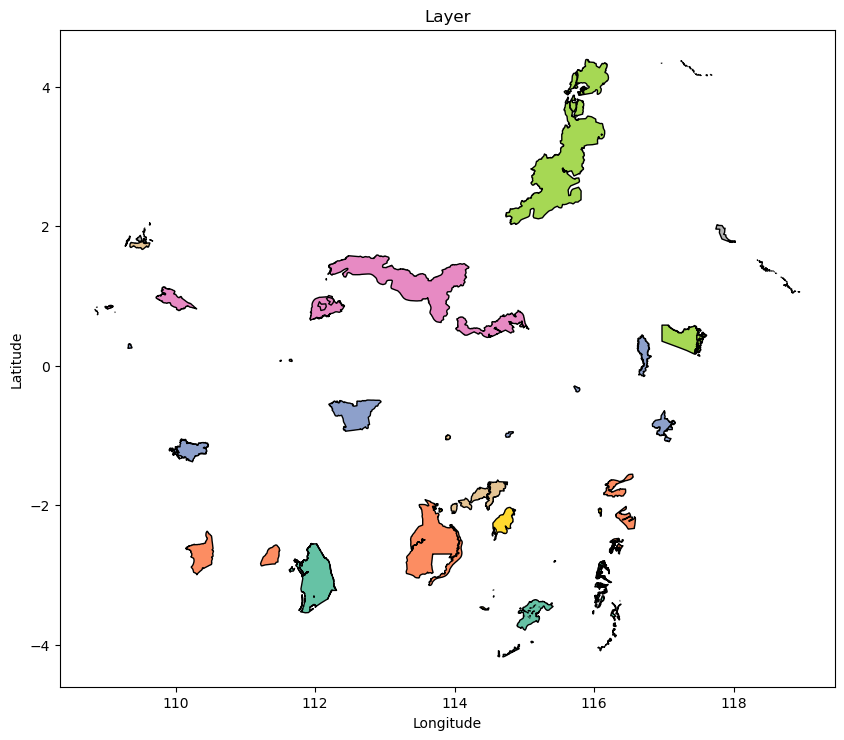

In [41]:
import matplotlib.pyplot as plt
# Plot the clipped layer
union1.plot(figsize=(10, 10), edgecolor='black', cmap='Set2')
plt.title("Layer")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [43]:
union1.head()

,WDPAID_1,WDPA_PID_1,PA_DEF_1,NAME_1,ORIG_NAME_1,DESIG_1,DESIG_ENG_1,DESIG_TYPE_1,IUCN_CAT_1,INT_CRIT_1,...,MANG_AUTH,MANG_PLAN,VERIF,METADATAID,SUB_LOC,PARENT_ISO,ISO3,SUPP_INFO,CONS_OBJ,geometry
0,62581.0,62581,1,Sungai Serudong,Sungai Serudong Protection Forest,Forest Reserve,Forest Reserve,National,Ia,Not Applicable,...,Sabah Forestry Department (SFD) / Sabah Founda...,Not Reported,State Verified,1998.0,Not Reported,MYS,MYS,Not Applicable,Not Applicable,"POLYGON ((117.52698 4.16218, 117.52699 4.16218..."
1,1899.0,1899,1,Kayan Mentarang,Kayan Mentarang,Taman Nasional,National Park,National,II,Not Applicable,...,Forest Department Sarawak (FDS),Not Reported,State Verified,1998.0,Not Reported,MYS,MYS,Not Applicable,Not Applicable,"MULTIPOLYGON (((115.91699 4.36953, 115.91699 4..."
2,1490.0,1490,1,Tanjung Puting,Tanjung Puting,National Park,National Park,National,II,Not Applicable,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((111.97168 -2.55556, 111.97191 ..."
3,62502.0,62502,1,Pleihari Tanah Laut,Pleihari Tanah Laut,Suaka Margasatwa,Wildlife Reserve,National,V,Not Applicable,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((114.91429 -4.02991, 114.91429 ..."
4,62493.0,62493,1,Sultan Adam,Sultan Adam,Taman Hutan Raya,Grand Forest Park,National,VI,Not Applicable,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((114.94494 -3.47916, 114.94566 ..."


In [45]:
union1.to_file('wdpa_merge.shp')

C:\Users\nooriza maharani\AppData\Local\Temp\ipykernel_17312\3250933960.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  union1.to_file('wdpa_merge.shp')
C:\Anaconda\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'ORIG_NAME_1' to 'ORIG_NAME_'
  ogr_write(
C:\Anaconda\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'DESIG_ENG_1' to 'DESIG_ENG_'
  ogr_write(
C:\Anaconda\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'DESIG_TYPE_1' to 'DESIG_TYPE'
  ogr_write(
C:\Anaconda\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'REP_M_AREA_1' to 'REP_M_AREA'
  ogr_write(
C:\Anaconda\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'GIS_M_AREA_1' to 'GIS_M_AREA'
  ogr_write(
C:\Anaconda\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normaliz

# Part 2 : Script for Visualizing the Result

## Pixel of Bivariate Map

In [102]:
pixel = gpd.read_file('bivariate_interest_n.shp')

In [104]:
pixel.crs

<Projected CRS: ESRI:102025>
Name: Asia_North_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [112]:
pixel.head(3)

,count,label,Shape_Leng,Shape_Area,name,geometry
0,0,0,41964.447455,1.057916e+08,A1,"POLYGON ((2012735.404 -3316280.25, 2025113.59 ..."
1,0,0,36292.180219,5.928179e+07,A2,"POLYGON ((1982612.494 -3317962.407, 1996249.83..."
2,0,0,19814.976045,2.405642e+07,A3,"POLYGON ((2059469.926 -3305169.234, 2065032.13..."


In [108]:
merged_aoh = gpd.read_file('merged_aoh.shp')

In [110]:
sorted_species = merged_aoh[['sci_name', 'category', 'min_alt','max_alt','habitat']].sort_values(by='category')
print(sorted_species)

                    sci_name category  min_alt  max_alt  \
32  Dicerorhinus sumatrensis       CR      0.0   2500.0   
28             Bos javanicus       CR      0.0   2100.0   
42            Manis javanica       CR      0.0   1700.0   
55     Presbytis chrysomelas       CR      0.0    100.0   
53            Pongo pygmaeus       CR      0.0    500.0   
..                       ...      ...      ...      ...   
30    Cephalopachus bancanus       VU      0.0   1200.0   
64             Rusa unicolor       VU      0.0   3900.0   
33           Diplogale hosei       VU    325.0   1700.0   
36      Hipposideros ridleyi       VU      0.0    500.0   
65  Trachypithecus cristatus       VU      0.0    300.0   

                                              habitat  
32                                             forest  
28                                 Data not available  
42  Forest, Shrubland, Artificial/Terrestrial, Art...  
55                                 Data not available  
53         

In [118]:
pixel_A2 = pixel[pixel['name'] == 'A2']

In [136]:
pixel_a2_p = pixel_A2.to_crs("EPSG:3857")

In [158]:
species = gpd.clip(merged_gdf, pixel_a2_p)

In [160]:
len(filtered_species)

45

In [164]:
filtered_species = species[['class','sci_name', 'category']].sort_values(by='category')
filtered_species

,class,sci_name,category
42,Mammalia,Manis javanica,CR
32,Mammalia,Dicerorhinus sumatrensis,CR
28,Mammalia,Bos javanicus,CR
53,Mammalia,Pongo pygmaeus,CR
37,Mammalia,Hylobates albibarbis,EN
48,Mammalia,Nasalis larvatus,EN
5,Aves,Berenicornis comatus,EN
40,Mammalia,Macaca fascicularis,EN
41,Mammalia,Macaca nemestrina,EN
31,Mammalia,Cynogale bennettii,EN


## H-H driver Species Weighted Richness

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# DF
data = {
    "Driver Code": [1, 2, 3, 4, 5],
    "Driver Name": [
        "Permanent agriculture",
        "Hard commodities",
        "Shifting cultivation",
        "Logging",
        "Wildfire"
    ],
    "Area (km²)": [24407.03, 3024.35, 10028.96, 47154.19, 8838.20]
}

df = pd.DataFrame(data)

# Sort
df_sorted = df.sort_values(by='Area (km²)', ascending=False)

plt.figure(figsize=(10,6))
plt.bar(df_sorted['Driver Name'], df_sorted['Area (km²)'], color='skyblue')

plt.xticks(rotation=45, ha='right', fontsize=12)  
plt.ylabel('Area (km²)', fontsize=12)
plt.title('Extent of Drivers in High-High Areas', fontsize=14)
plt.tight_layout()
plt.show()
